##**MNIST**

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

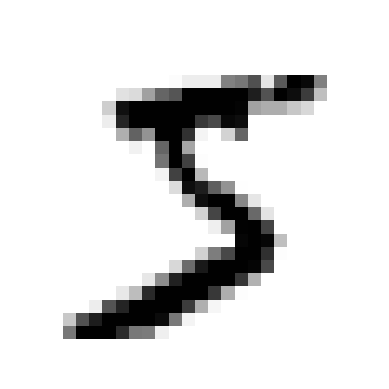

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##**Training a Binary Classifier**

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import numpy as np

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)

    # X_train assumed to be DataFrame → use .iloc
    X_train_folds = X_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]

    # y_train_5 is ndarray → use standard indexing
    y_train_folds = y_train_5[train_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = np.sum(y_pred == y_test_fold)
    print("Akurasi fold:", n_correct / len(y_pred))


Akurasi fold: 0.9669
Akurasi fold: 0.91625
Akurasi fold: 0.96785


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

##**Confusion Matrix**

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                              method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

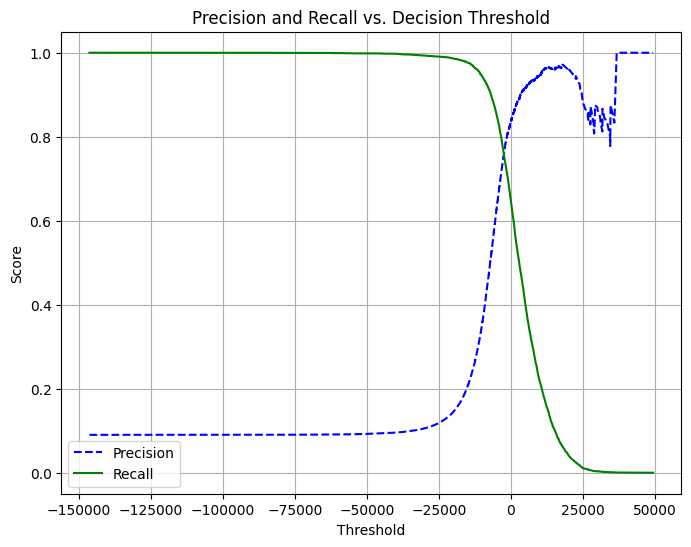

In [26]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 6))

    # Garis precision dan recall terhadap threshold
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    # Label sumbu dan legend
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs. Decision Threshold")
    plt.legend(loc="best")
    plt.grid(True)

# Contoh pemanggilan fungsi (pastikan `precisions`, `recalls`, dan `thresholds` sudah tersedia)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

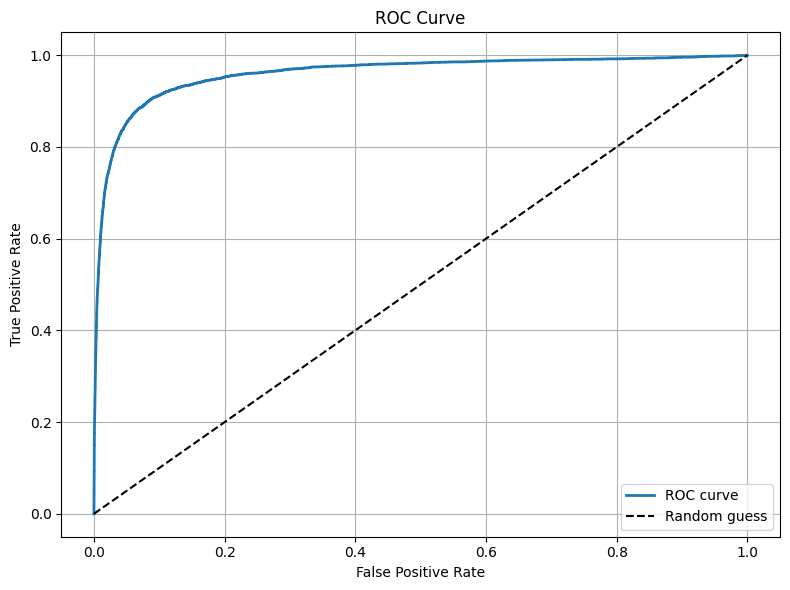

In [32]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label or "ROC curve")
    plt.plot([0, 1], [0, 1], 'k--', label="Random guess")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()

plot_roc_curve(fpr, tpr)
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [35]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

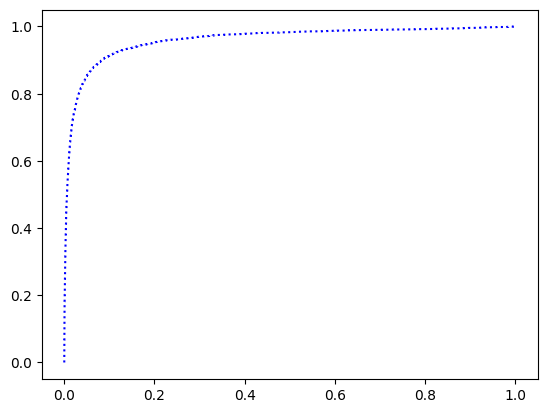

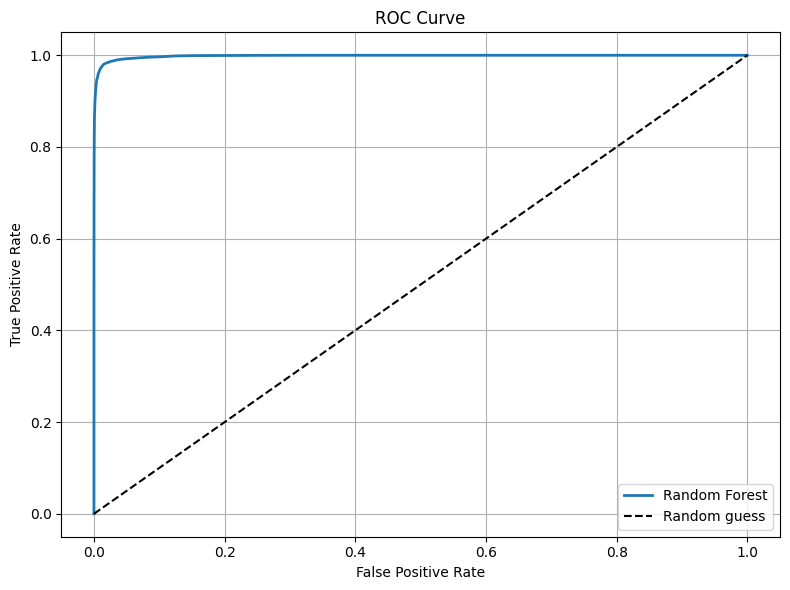

In [36]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

##**Multiclass Classification**

In [38]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [40]:
np.argmax(some_digit_scores)

np.int64(5)

In [41]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
svm_clf.classes_[5]

np.uint8(5)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)